In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow-addons
!unzip /content/drive/MyDrive/MURA-v1.1.zip

In [ ]:
import os 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169, InceptionV3
from tensorflow.keras.utils import Sequence

### Functions and Classes that will be used throughout this notebook

In [ ]:
def label_count(labels_df):
    """
    Counts the number of instances for each label and body part
    """
    img_label_count = {}

    for xr_type in list(pd.unique(labels_df.XR_type)):
        tmp = labels_df.loc[labels_df.XR_type == xr_type]
        normal, abnormal = 0, 0

        for i in range(len(tmp)):
            if tmp.iloc[i, 1] == 1:
                abnormal += len(os.listdir(tmp.iloc[i, 0]))
            else:
                normal += len(os.listdir(tmp.iloc[i, 0]))

        img_label_count[xr_type] = {}
        img_label_count[xr_type]['normal'] = normal
        img_label_count[xr_type]['abnormal'] = abnormal

    return img_label_count

In [ ]:
# Helper functions for plots
def plot_history(history):
    """
    Plots training history.
    """
    fig = plt.figure(figsize=(20,5))
    fig.suptitle("Training/Validation Results", fontsize=17)
    fig.patch.set_alpha(1)

    for i in range(0, 3):
        ax = fig.add_subplot(1,3,i+1)
        ax.plot(history[list(history.keys())[i]], c='r', 
                label='Training Loss' if i==0 else 'Training Cohen Kappa' if i==1 else 'Training Accuracy')
        ax.plot(history[list(history.keys())[i+3]], c='k',
                label='Validation Loss' if i==0 else 'Validation Cohen Kappa' if i==1 else 'Validation Accuracy')
        ax.legend(fontsize=11, loc='lower right' if i in [1,2] else 'upper right')
        ax.set_xlabel('Epochs', fontsize=14)
        ax.set_ylabel('Loss' if i==0 else 'Cohen Kappa' if i==1 else 'Accuracy', fontsize=15)
    return plt.show()

def plot_cm(true_labels, predicted_labels, title):
    """
    Plots a Confusion Matrix
    """
    fig = plt.figure(figsize=(10,7))
    fig.patch.set_alpha(1)

    cm = confusion_matrix(true_labels, predicted_labels)
    ax = fig.add_subplot(111)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu",  annot_kws={"size":14}, 
                yticklabels=['Normal', 'Abnormal'], xticklabels=['Normal', 'Abnormal']);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel('Predicted labels', fontsize=15);ax.set_ylabel('True labels', fontsize=15)
    ax.set_title(f'Confusion Matrix for {title[3:].capitalize()} Predictions', fontsize=18)
    return plt.show()

def roc_auc_plot(true_labels, predicted_labels):
    """
    Plots the ROC curve.
    """
    fig = plt.figure(figsize=(9,6))
    fig.patch.set_alpha(1)

    fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
    auc_value = auc(fpr, tpr)

    ax = fig.add_subplot(111)
    ax.plot([0,1], [0,1], '--', color='k', label='Baseline')
    ax.plot(fpr, tpr, marker='.', color='#C32E5A', label=f"ROC Curve (area = {round(auc_value,3)})")
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.set_title(f"Ensemble's ROC Curve", fontsize=14)
    ax.legend(loc='lower right', fontsize=12)

    return plt.show()

In [ ]:
class TwoInputGenerator(Sequence):
    """Wrapper for two generators, for two input architectures"""

    def __init__(self, gen, dict_params):
        self.generator = gen  # keras generator
        self.params = dict_params # parameters for flow_from_dataframe
        self.genX1 = self.generator.flow_from_dataframe(**self.params, target_size=(299,299))  # for inception
        self.genX2 = self.generator.flow_from_dataframe(**self.params, target_size=(224,224))  # for densenet

    def __len__(self):
        """It is mandatory to implement it on Keras Sequence"""
        return self.genX1.__len__()

    def __getitem__(self, index):
        """Yielding two batches of X for the two inputs"""
        X1_batch, Y_batch = self.genX1.__getitem__(index)
        X2_batch, Y_batch = self.genX2.__getitem__(index)

        X_batch = [X1_batch, X2_batch]

        return X_batch, Y_batch

In [ ]:
class ReturnBestEarlyStopping(EarlyStopping):
    """
    If the maximum epoch is reached, then retain the best performing weights.
    """
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

In [ ]:
def bodypart_errors(ensemble_label_preds, test_labels, bodypart):
    """
    Error analysis function.
    """
    ensemble_bodypart = ensemble_label_preds[test_labels.loc[test_labels.XR_type == bodypart].index].reshape(-1,)
    true_bodypart = test_labels.loc[test_labels.XR_type == bodypart].label.to_numpy().astype(int)

    print(f'Ensemble cohen kappa: {cohen_kappa_score(true_bodypart, ensemble_bodypart)}\n')
    print(f'Ensemble\'s Classification Report:\n{classification_report(true_bodypart, ensemble_bodypart)}\n')

    return plot_cm(true_bodypart, ensemble_bodypart, bodypart)

### Preprocessing

In [ ]:
# read labels
train_labels = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'])
test_labels = pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'])
train_labels.head()

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [ ]:
train_labels['XR_type'] = train_labels.path.apply(lambda x: re.findall(r'/(\w+)', x)[1])  # Create a new column with the type of x-ray
test_labels['XR_type'] = test_labels.path.apply(lambda x: re.findall(r'/(\w+)', x)[1])  

In [ ]:
train_labels.drop(train_labels[~train_labels.XR_type.isin(['XR_HAND', 'XR_SHOULDER', 'XR_FINGER'])].index, inplace=True)  # keep only the three bodyparts
train_labels

,path,label,XR_type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,XR_SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,XR_SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,XR_SHOULDER
...,...,...,...
13452,MURA-v1.1/train/XR_HAND/patient11180/study1_ne...,0,XR_HAND
13453,MURA-v1.1/train/XR_HAND/patient11181/study1_ne...,0,XR_HAND
13454,MURA-v1.1/train/XR_HAND/patient11182/study1_ne...,0,XR_HAND
13455,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0,XR_HAND


In [ ]:
train_label_count = label_count(train_labels)
print(train_label_count)  # imbalanced

{'XR_SHOULDER': {'normal': 4211, 'abnormal': 4168}, 'XR_FINGER': {'normal': 3138, 'abnormal': 1968}, 'XR_HAND': {'normal': 4059, 'abnormal': 1484}}


In [ ]:
# Read image paths
train_image_paths = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None, names=['img_path'])
test_image_paths = pd.read_csv('MURA-v1.1/valid_image_paths.csv', header=None, names=['img_path'])

In [ ]:
# Extract more information for each image
train_image_paths['patient'] = train_image_paths.img_path.apply(lambda x: re.findall(r'/(\w+)', x)[2])
train_image_paths['path'] = train_image_paths.img_path.apply(lambda x: '/'.join(x.split('/')[:-1]) + '/')
train_image_paths['img'] = train_image_paths.img_path.apply(lambda x: x.split('/')[-1])

test_image_paths['patient'] = test_image_paths.img_path.apply(lambda x: re.findall(r'/(\w+)', x)[2])
test_image_paths['path'] = test_image_paths.img_path.apply(lambda x: '/'.join(x.split('/')[:-1]) + '/')
test_image_paths['img'] = test_image_paths.img_path.apply(lambda x: x.split('/')[-1])

In [ ]:
# Create the final dataframes
train_data = pd.merge(train_image_paths, train_labels, left_on='path', right_on='path')
train_data.drop(columns=['path'], inplace=True)

test_data = pd.merge(test_image_paths, test_labels, left_on='path', right_on='path')
test_data.drop(columns=['path'], inplace=True)

In [ ]:
print(f'There are {len(train_data)} unique hand X-rays')

There are 19028 unique hand X-rays


In [ ]:
train_data = train_data.sample(frac=1).reset_index(drop=True)  #shuffle train dataframe
train_data.head()

,img_path,patient,img,label,XR_type
0,MURA-v1.1/train/XR_HAND/patient10305/study1_ne...,patient10305,image2.png,0,XR_HAND
1,MURA-v1.1/train/XR_SHOULDER/patient00989/study...,patient00989,image1.png,1,XR_SHOULDER
2,MURA-v1.1/train/XR_FINGER/patient04612/study1_...,patient04612,image4.png,0,XR_FINGER
3,MURA-v1.1/train/XR_HAND/patient10443/study1_ne...,patient10443,image2.png,0,XR_HAND
4,MURA-v1.1/train/XR_FINGER/patient03508/study1_...,patient03508,image3.png,1,XR_FINGER


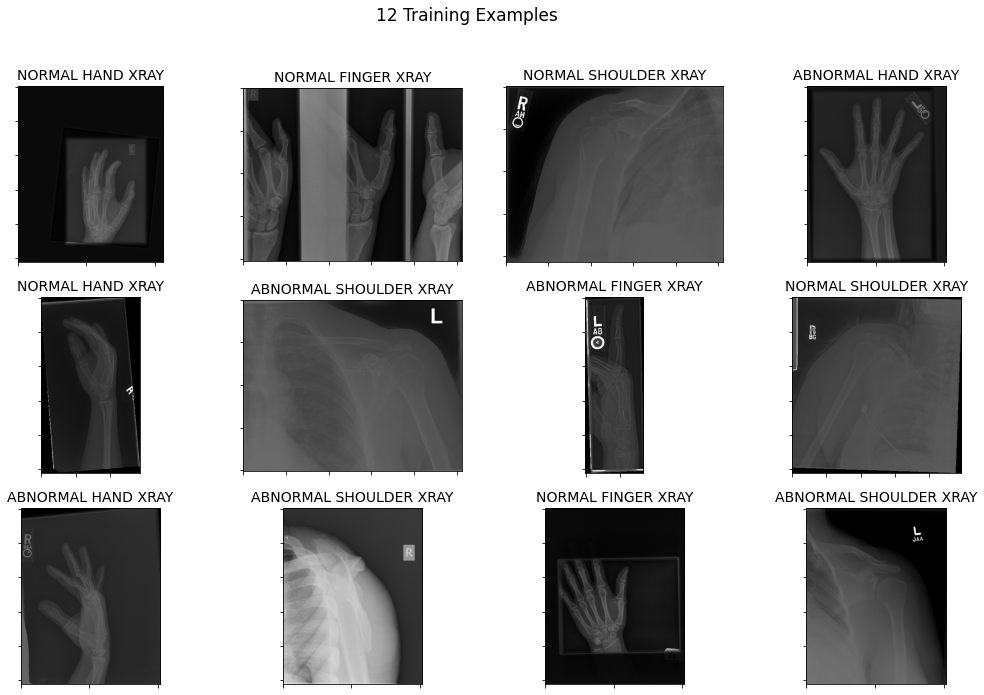

In [ ]:
fig = plt.figure(figsize=(18,11))
fig.patch.set_alpha(1)
fig.suptitle('12 Training Examples', size=17)

ab, nor = 'ABNORMAL', 'NORMAL'
for i in range(12):
    img = cv2.imread(train_data.iloc[i,0])
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(img)
    ax.set_title(f'{ab if train_data.iloc[i,3] else nor} {train_data.iloc[i,4][3:]} XRAY', size=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Generator

In [ ]:
train_data['label'] = train_data['label'].astype(str)  # for the generator
test_data['label'] = test_data['label'].astype(str)

In [ ]:
train, val = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data.label)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    rotation_range=30,
    fill_mode='constant'
)

train_params = {
    'dataframe': train,
    'x_col': 'img_path',
    'y_col': 'label',
    'seed': 42,
    'shuffle': True,
    'class_mode': 'binary',
    'batch_size': 32
}
train_generator = TwoInputGenerator(train_datagen, train_params)

val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

val_params = {
    'dataframe': val,
    'x_col': 'img_path',
    'y_col': 'label',
    'seed': 42,
    'shuffle': True,
    'class_mode': 'binary',
    'batch_size': 32
}

val_generator = TwoInputGenerator(val_test_datagen, val_params)

test_params = {
    'dataframe': test_data,
    'x_col': 'img_path',
    'y_col': 'label',
    'batch_size': 32,
    'class_mode': 'binary',
    'shuffle': False  # important for the metrics
}

test_generator = TwoInputGenerator(val_test_datagen, test_params)

Found 16173 validated image filenames belonging to 2 classes.
Found 16173 validated image filenames belonging to 2 classes.
Found 2855 validated image filenames belonging to 2 classes.
Found 2855 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
METRICS = [
           tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
           'accuracy'
]

### DenseNet169 and InceptionV3 ensemble

In [ ]:
# InceptionV3 Model
incept = InceptionV3(
    weights='imagenet', 
    include_top=False,
    input_shape=(299,299,3)
)

for i, layer in enumerate(incept.layers):
    layer.trainable = False
    layer._name = f'inc_layer_{i}'

reduce_incept = Conv2D(kernel_size=(1,1), filters=512, activation='relu')(incept.output)
inc_drpt = Dropout(rate=0.3)(reduce_incept)
incept_gap = GlobalAveragePooling2D()(inc_drpt)

#DenseNet Model
densenet = DenseNet169(
    weights='imagenet', 
    include_top=False,
    input_shape=(224,224,3)
)

for i, layer in enumerate(densenet.layers):
    layer.trainable = False
    layer._name = f'dense_layer_{i}'

reduce_densenet = Conv2D(kernel_size=(1,1), filters=512, activation='relu')(densenet.output)
dens_drpt = Dropout(rate=0.3)(reduce_densenet)
densenet_gap = GlobalAveragePooling2D()(dens_drpt)

# concatenate
concat = concatenate([incept_gap, densenet_gap])

output_ensemble = Dense(units=1, activation='sigmoid')(concat)

ensemble_model = Model(inputs=[incept.input, densenet.input], outputs=output_ensemble)
ensemble_model.compile(metrics=METRICS, optimizer=Adam(1e-4), loss='binary_crossentropy')

In [ ]:
ensemble_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
    ReturnBestEarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]
history = ensemble_model.fit(
    train_generator, 
    epochs=30,  
    callbacks=ensemble_callbacks, 
    validation_data=val_generator
    )

Epoch 1/30
506/506 [==============================] - 577s 1s/step - loss: 0.5947 - cohen_kappa: 0.3424 - accuracy: 0.6809 - val_loss: 0.5967 - val_cohen_kappa: 0.3398 - val_accuracy: 0.6732 - lr: 1.0000e-04
Epoch 2/30
506/506 [==============================] - 570s 1s/step - loss: 0.5542 - cohen_kappa: 0.4062 - accuracy: 0.7242 - val_loss: 0.5744 - val_cohen_kappa: 0.3998 - val_accuracy: 0.7068 - lr: 1.0000e-04
Epoch 3/30
506/506 [==============================] - 566s 1s/step - loss: 0.5371 - cohen_kappa: 0.4307 - accuracy: 0.7355 - val_loss: 0.5999 - val_cohen_kappa: 0.3611 - val_accuracy: 0.6764 - lr: 1.0000e-04
Epoch 4/30
506/506 [==============================] - 566s 1s/step - loss: 0.5288 - cohen_kappa: 0.4436 - accuracy: 0.7407 - val_loss: 0.5524 - val_cohen_kappa: 0.4265 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 5/30
506/506 [==============================] - 562s 1s/step - loss: 0.5178 - cohen_kappa: 0.4683 - accuracy: 0.7520 - val_loss: 0.5686 - val_cohen_kappa: 0.4095 

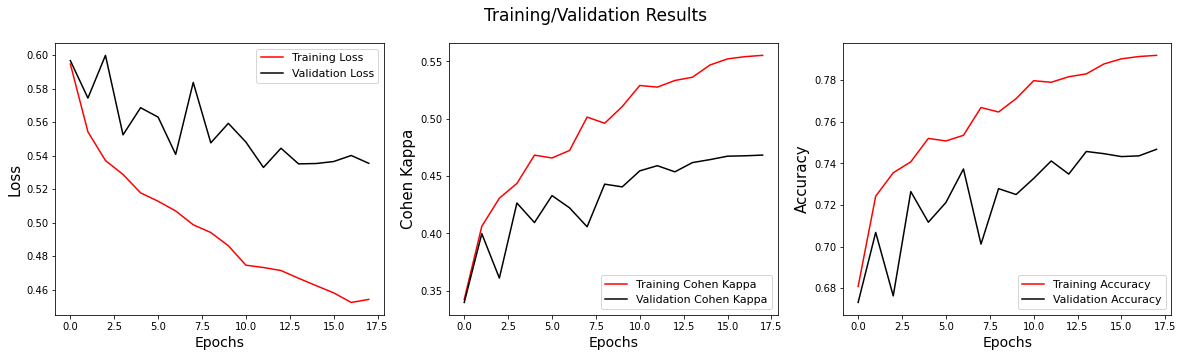

In [ ]:
plot_history(history.history)

In [ ]:
for layer in ensemble_model.layers:
    layer.trainable = True

ensemble_model.compile(optimizer=Adam(learning_rate=5e-6), metrics=METRICS, loss='binary_crossentropy')

In [ ]:
final_ensemble_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]
history = ensemble_model.fit(
    train_generator, 
    epochs=30,  
    callbacks=final_ensemble_callbacks, 
    validation_data=val_generator,
    shuffle=True
)

Epoch 1/30
506/506 [==============================] - 783s 1s/step - loss: 0.5659 - cohen_kappa: 0.3904 - accuracy: 0.7142 - val_loss: 0.6224 - val_cohen_kappa: 0.3728 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 2/30
506/506 [==============================] - 690s 1s/step - loss: 0.5063 - cohen_kappa: 0.4914 - accuracy: 0.7611 - val_loss: 0.5030 - val_cohen_kappa: 0.4924 - val_accuracy: 0.7643 - lr: 5.0000e-06
Epoch 3/30
506/506 [==============================] - 689s 1s/step - loss: 0.4704 - cohen_kappa: 0.5344 - accuracy: 0.7811 - val_loss: 0.4856 - val_cohen_kappa: 0.5184 - val_accuracy: 0.7748 - lr: 5.0000e-06
Epoch 4/30
506/506 [==============================] - 692s 1s/step - loss: 0.4458 - cohen_kappa: 0.5712 - accuracy: 0.7982 - val_loss: 0.4897 - val_cohen_kappa: 0.5291 - val_accuracy: 0.7807 - lr: 5.0000e-06
Epoch 5/30
506/506 [==============================] - 690s 1s/step - loss: 0.4237 - cohen_kappa: 0.5933 - accuracy: 0.8086 - val_loss: 0.5014 - val_cohen_kappa: 0.5098 

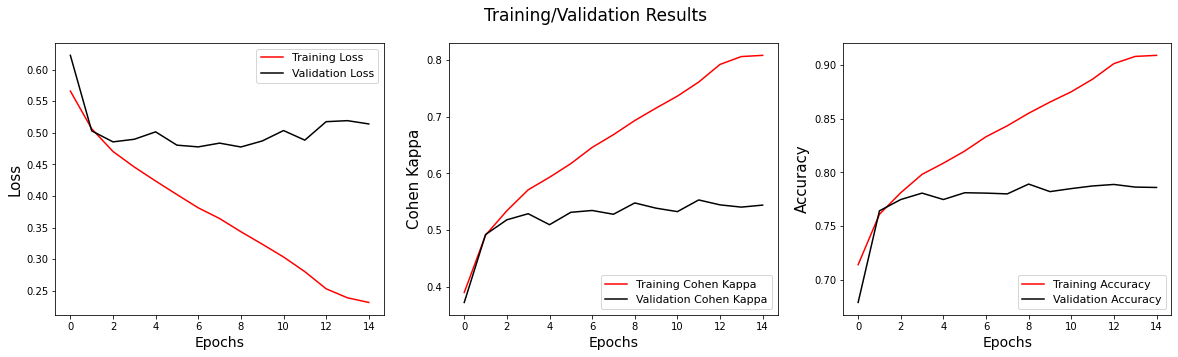

In [ ]:
plot_history(history.history)

#### Error Analysis

In [ ]:
ensemble_preds = ensemble_model.predict(test_generator)
ensemble_label_preds = np.where(ensemble_preds > 0.5, 1, 0)

true_labels = test_data.label.to_numpy().astype(int)

In [ ]:
print(f'Ensemble cohen kappa for all bodyparts: {cohen_kappa_score(true_labels, ensemble_label_preds)}')

Ensemble cohen kappa for all bodyparts: 0.42017423305103185


In [ ]:
print(f'Ensemble\'s Predictions:\n{classification_report(true_labels, ensemble_label_preds)}')

Ensemble's Predictions:
              precision    recall  f1-score   support

           0       0.70      0.77      0.74      1667
           1       0.72      0.64      0.68      1530

    accuracy                           0.71      3197
   macro avg       0.71      0.71      0.71      3197
weighted avg       0.71      0.71      0.71      3197



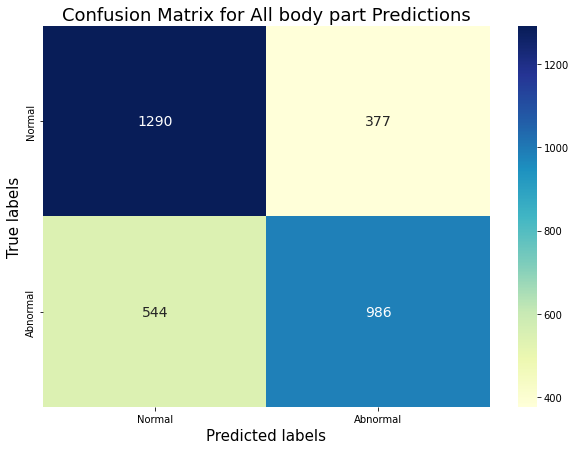

In [ ]:
plot_cm(true_labels, ensemble_label_preds, '   all Body Part')

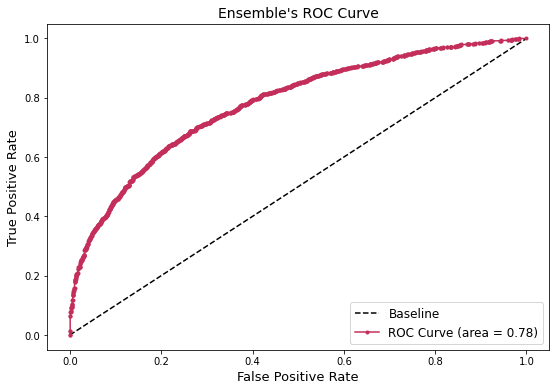

In [ ]:
roc_auc_plot(true_labels, ensemble_preds)

### Body Parts

In [ ]:
kappas = {}
for bodypart in pd.unique(test_data.XR_type):
    ensemble_bodypart = ensemble_label_preds[test_data.loc[test_data.XR_type == bodypart].index].reshape(-1,)
    true_bodypart = test_data.loc[test_data.XR_type == bodypart].label.to_numpy().astype(int)
    kappas[bodypart[3:]] = cohen_kappa_score(true_bodypart, ensemble_bodypart)

kappas

{'ELBOW': 0.27926930528646565,
 'FINGER': 0.4822099898820187,
 'FOREARM': 0.35625620108036593,
 'HAND': 0.43475773818351315,
 'HUMERUS': 0.3123673548138144,
 'SHOULDER': 0.5274371580216216,
 'WRIST': 0.42377596872764345}

It seems that for all the three body parts, the cohen kappa score increased. The largest improvement is observed in shoulders (11% higher than DenseNet's predictions).

###Hand X-RAYs

Ensemble cohen kappa: 0.43475773818351315

Ensemble's Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       271
           1       0.90      0.43      0.59       189

    accuracy                           0.75       460
   macro avg       0.81      0.70      0.70       460
weighted avg       0.79      0.75      0.72       460




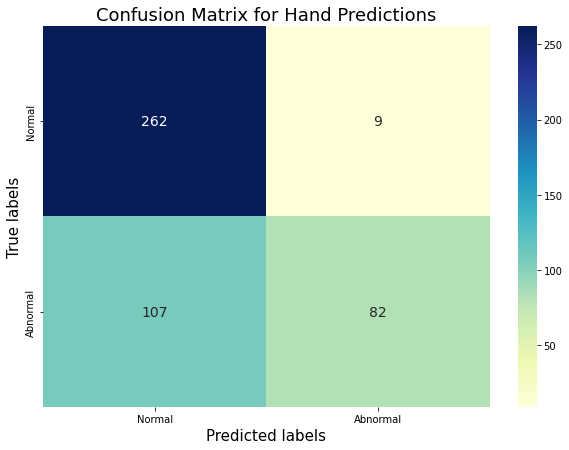

In [ ]:
bodypart_errors(ensemble_label_preds, test_data, 'XR_HAND')

False negatives and were increased by 6, but false positives were decreased by 9. This resulted to an improvement for most of the scores (except recall and f1 for the abnormal class).

### Shoulder X-RAYs

Ensemble cohen kappa: 0.5274371580216216

Ensemble's Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       285
           1       0.76      0.76      0.76       278

    accuracy                           0.76       563
   macro avg       0.76      0.76      0.76       563
weighted avg       0.76      0.76      0.76       563




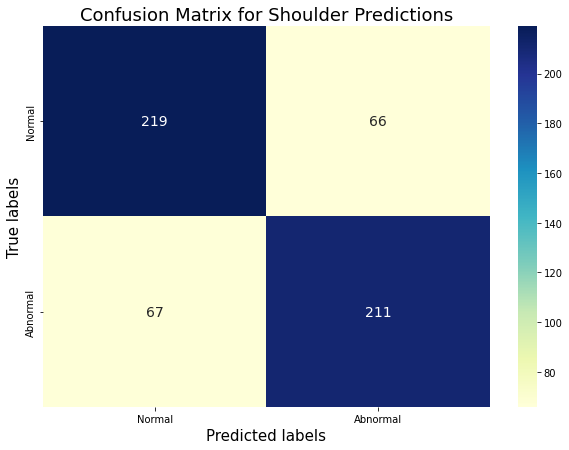

In [ ]:
bodypart_errors(ensemble_label_preds, test_data, 'XR_SHOULDER')

Both false positives and false negatives were decreased, which improved the score for all metrics. 

### Finger X-RAYs

Ensemble cohen kappa: 0.4822099898820187

Ensemble's Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       214
           1       0.84      0.63      0.72       247

    accuracy                           0.74       461
   macro avg       0.75      0.75      0.74       461
weighted avg       0.76      0.74      0.74       461




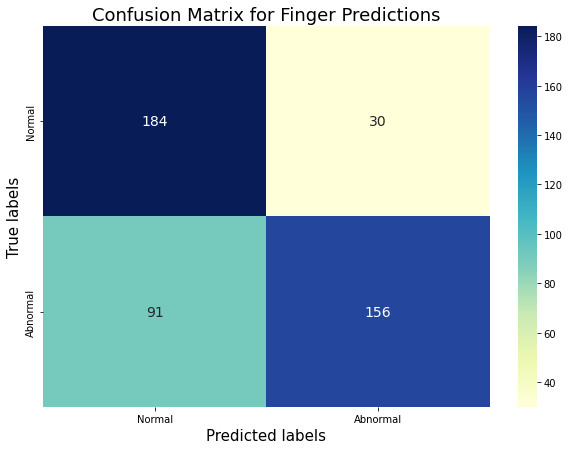

In [ ]:
bodypart_errors(ensemble_label_preds, test_data, 'XR_FINGER')

False positives were decreased by 20 but false negatives were increased by 17. This resulted to better scores for all the metrics except recall and f1 of the normal class.

### Using the Ensemble model for Hands, Shoulders and Fingers, and the DenseNet model for the rest

In [ ]:
ensemble_labels = test_labels[test_labels.XR_type.isin(['XR_HAND', 'XR_SHOULDER', 'XR_FINGER'])]
ensemble_data = pd.merge(test_image_paths, ensemble_labels, left_on='path', right_on='path')

densenet_labels = test_labels[~test_labels.XR_type.isin(['XR_HAND', 'XR_SHOULDER', 'XR_FINGER'])]
densenet_data = pd.merge(test_image_paths, densenet_labels, left_on='path', right_on='path')

In [ ]:
ensemble_data['label'] = ensemble_data['label'].astype(str)  # for the generator
densenet_data['label'] = densenet_data['label'].astype(str)

ensemble_params = {
    'dataframe': ensemble_data,
    'x_col': 'img_path',
    'y_col': 'label',
    'batch_size': 32,
    'class_mode': 'binary',
    'shuffle': False  # important for the metrics
}
ensemble_generator = TwoInputGenerator(val_test_datagen, ensemble_params)

densenet_generator = val_test_datagen.flow_from_dataframe(
    dataframe=densenet_data,
    x_col='img_path',
    y_col='label',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224),
    shuffle=False  # important for the metrics
)

Found 1484 validated image filenames belonging to 2 classes.
Found 1484 validated image filenames belonging to 2 classes.
Found 1713 validated image filenames belonging to 2 classes.


In [ ]:
densenet_model = tf.keras.models.load_model('/content/drive/MyDrive/finetuned_densenet_MURA')

In [ ]:
ensemble_preds = ensemble_model.predict(ensemble_generator)
ensemble_label_preds = np.where(ensemble_preds > 0.5, 1, 0)
true_ensemble = ensemble_data.label.to_numpy().astype(int)

densenet_preds = densenet_model.predict(densenet_generator)
densenet_label_preds = np.where(densenet_preds > 0.5, 1, 0)
true_densenet = densenet_data.label.to_numpy().astype(int)

In [ ]:
true_labels = np.concatenate((true_ensemble, true_densenet))
pred_labels = np.concatenate((ensemble_label_preds, densenet_label_preds))

Ensemble cohen kappa for all bodyparts: 0.5673015206811567

Ensemble's Predictions:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1667
           1       0.87      0.65      0.74      1530

    accuracy                           0.79      3197
   macro avg       0.81      0.78      0.78      3197
weighted avg       0.80      0.79      0.78      3197



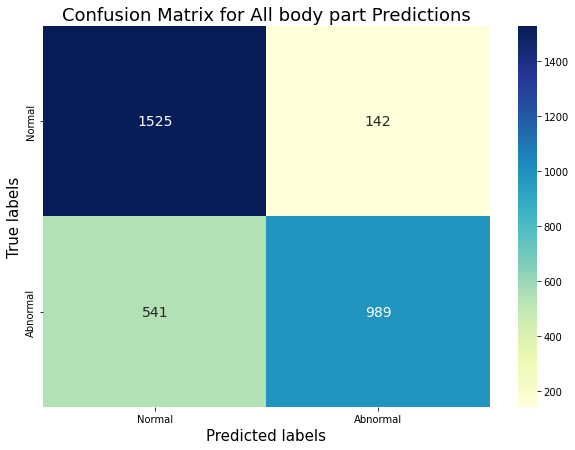

In [ ]:
print(f'Ensemble cohen kappa for all bodyparts: {cohen_kappa_score(true_labels, pred_labels)}\n')
print(f'Ensemble\'s Predictions:\n{classification_report(true_labels, pred_labels)}')
plot_cm(true_labels, pred_labels, '   all Body Part')

Overall the false positives were decreased by 21, which resulted to a better performance and higher metrics.